In [1]:
import cv2 as cv
from matplotlib import pyplot as plt
import glob
import numpy as np
import os

In [2]:
def draw_matches(img1, kp1, img2, kp2, matches): 
    """
    Python implementation of draw matches to allow configuration of line width and colour
    """
    if len(img1.shape) == 3:
        new_shape = (max(img1.shape[0], img2.shape[0]), img1.shape[1]+img2.shape[1], img1.shape[2])
    elif len(img1.shape) == 2:
        new_shape = (max(img1.shape[0], img2.shape[0]), img1.shape[1]+img2.shape[1])
    new_img = np.zeros(new_shape, type(img1.flat[0]))  
    new_img[0:img1.shape[0],0:img1.shape[1]] = img1
    new_img[0:img2.shape[0],img1.shape[1]:img1.shape[1]+img2.shape[1]] = img2
    r = 15
    thickness = 5
    red = (0, 0, 255)
    for m in matches:
        end1 = tuple(np.round(kp1[m.queryIdx].pt).astype(int))
        end2 = tuple(np.round(kp2[m.trainIdx].pt).astype(int) + np.array([img1.shape[1], 0]))
        cv.line(new_img, end1, end2, red, thickness)
        cv.circle(new_img, end1, r, red, thickness)
        cv.circle(new_img, end2, r, red, thickness)
    plt.figure(figsize=(10,10))
    plt.imshow(new_img)
    plt.show()

In [3]:
def draw_matches_manual(img1, kp1, img2, kp2): 
    """
    Python implementation of draw matches to allow drawing manual keypoint correspondences
    """
    if len(img1.shape) == 3:
        new_shape = (max(img1.shape[0], img2.shape[0]), img1.shape[1]+img2.shape[1], img1.shape[2])
    elif len(img1.shape) == 2:
        new_shape = (max(img1.shape[0], img2.shape[0]), img1.shape[1]+img2.shape[1])
    new_img = np.zeros(new_shape, type(img1.flat[0]))  
    new_img[0:img1.shape[0],0:img1.shape[1]] = img1
    new_img[0:img2.shape[0],img1.shape[1]:img1.shape[1]+img2.shape[1]] = img2
    r = 15
    thickness = 5
    red = (0, 0, 255)
    for i in range(len(kp1)):
        end1 = tuple(np.round(kp1[i]).astype(int))
        end2 = tuple(np.round(kp2[i]).astype(int) + np.array([img1.shape[1], 0]))
        cv.line(new_img, end1, end2, red, thickness)
        cv.circle(new_img, end1, r, red, thickness)
        cv.circle(new_img, end2, r, red, thickness)
    plt.figure(figsize=(15,15))
    plt.imshow(new_img)
    plt.show()

### Load Images

In [4]:
filenames = glob.glob("photos/*.jpg")
print(f"{len(filenames)} images found")
images = [cv.imread(f) for f in filenames]

27 images found


In [5]:
print(filenames[15], filenames[16])

photos/hg2.jpg photos/IMG_1826.HEIC.jpg


### Display Images

In [6]:
rows = len(images) // 5
cols = (len(images) // rows) + 1

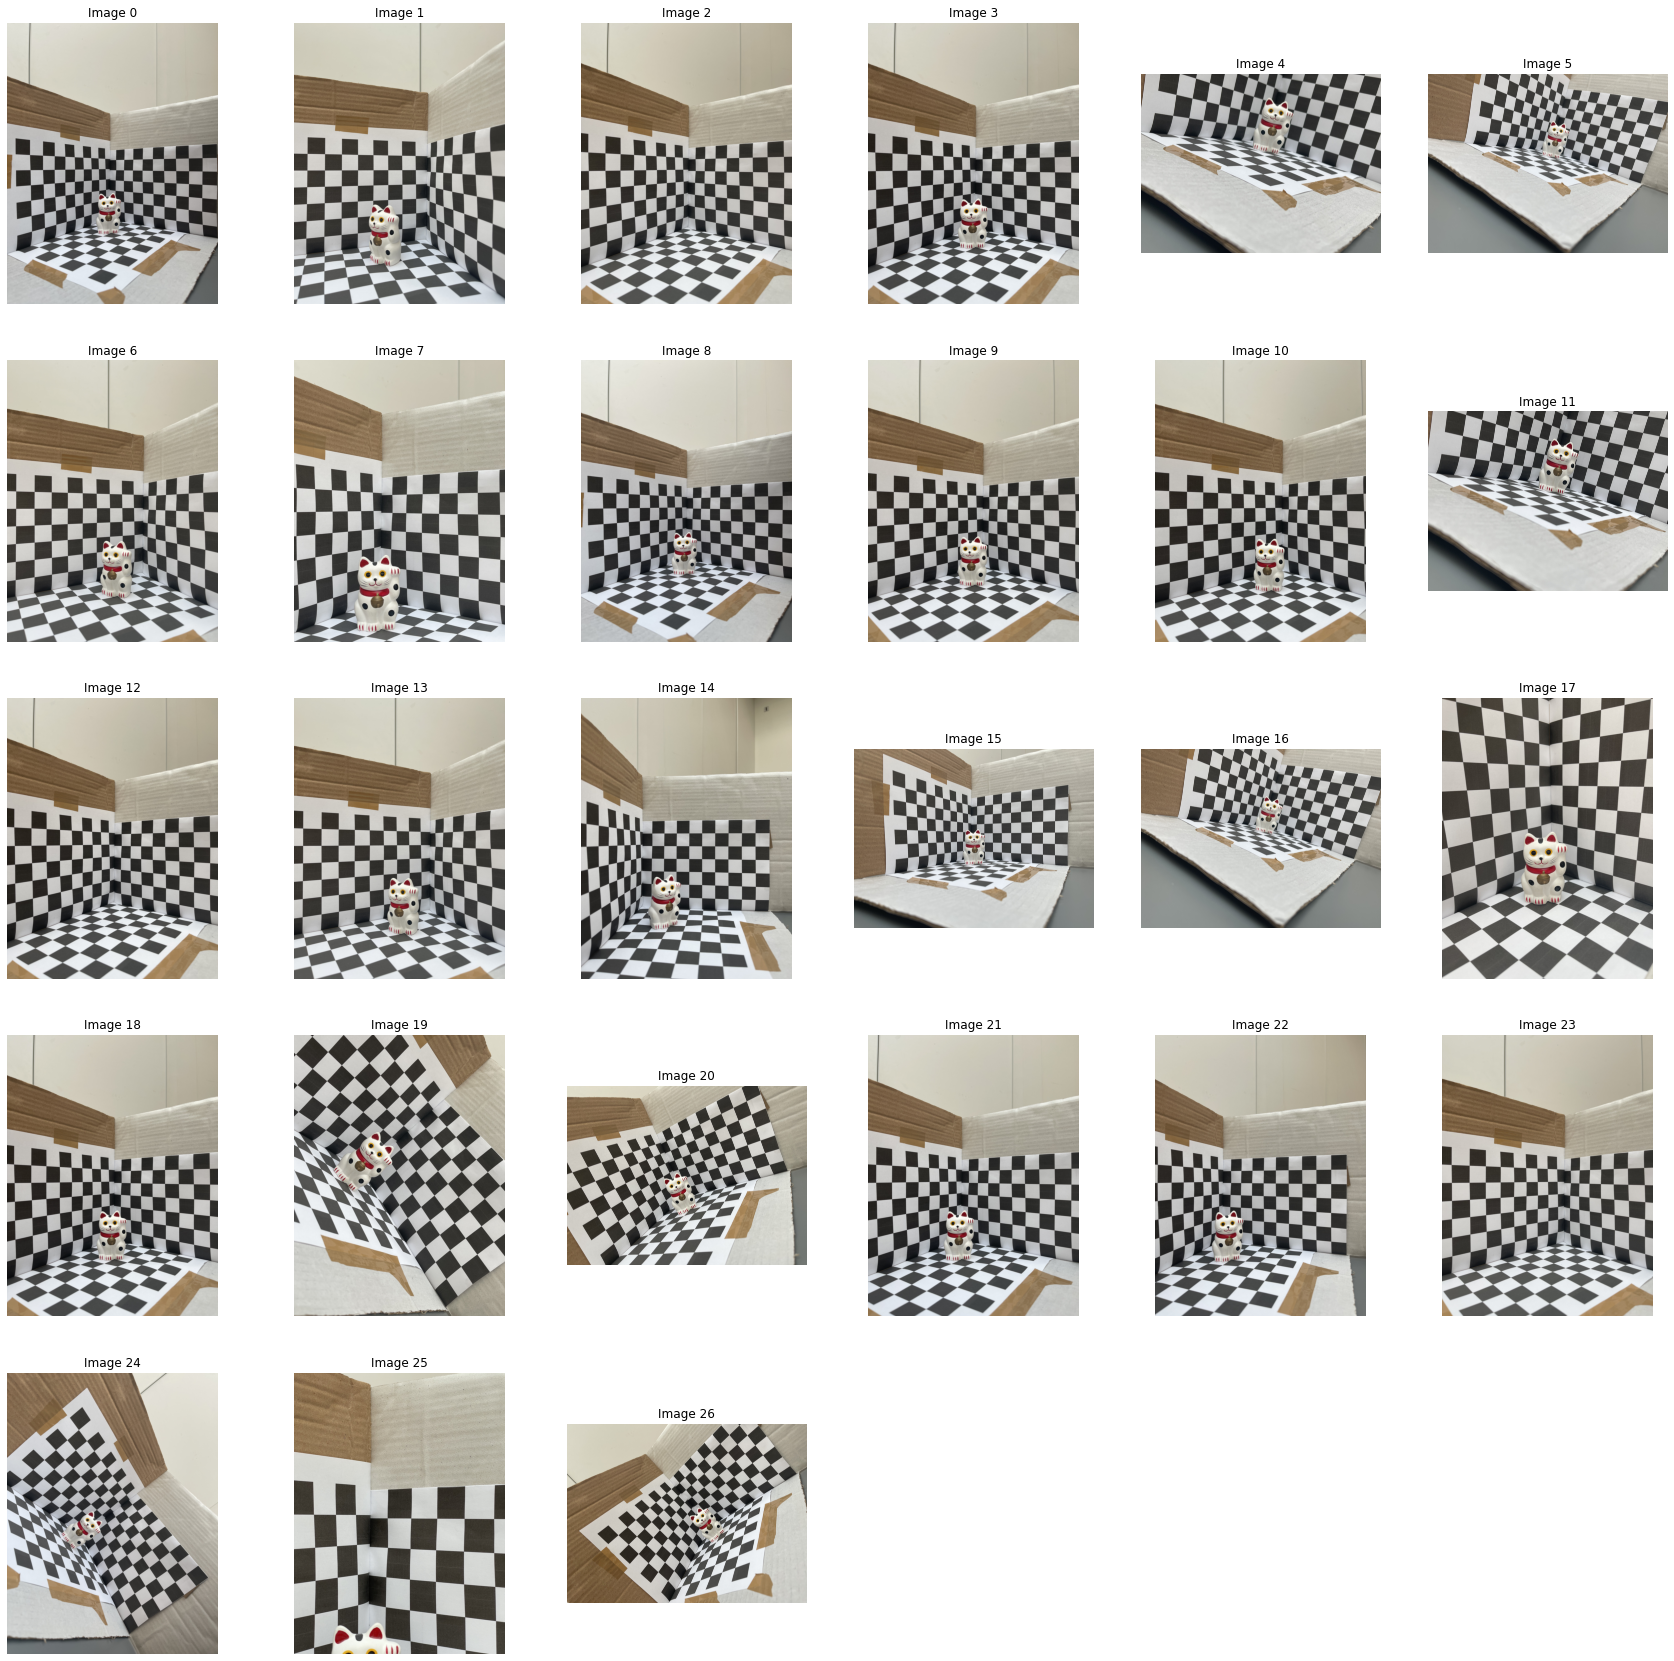

In [7]:
# This cell takes a while to run :( - consider commenting out if re-running notebook

fig = plt.figure(figsize=(30, 30))
for i in range(len(images)):
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(images[i][...,::-1]) # BGR to RGB - OpenCV image to Matplotlib
    plt.axis("off")
    plt.title(f"Image {i}")

### Keypoint correspondences between images
Compare quality/quantity of correspondences found by two methods:
- Manual (clicking on corresponding points)
- Automatic (detecting keypoint and matching descriptors)

#### Manual keypoint correspondence

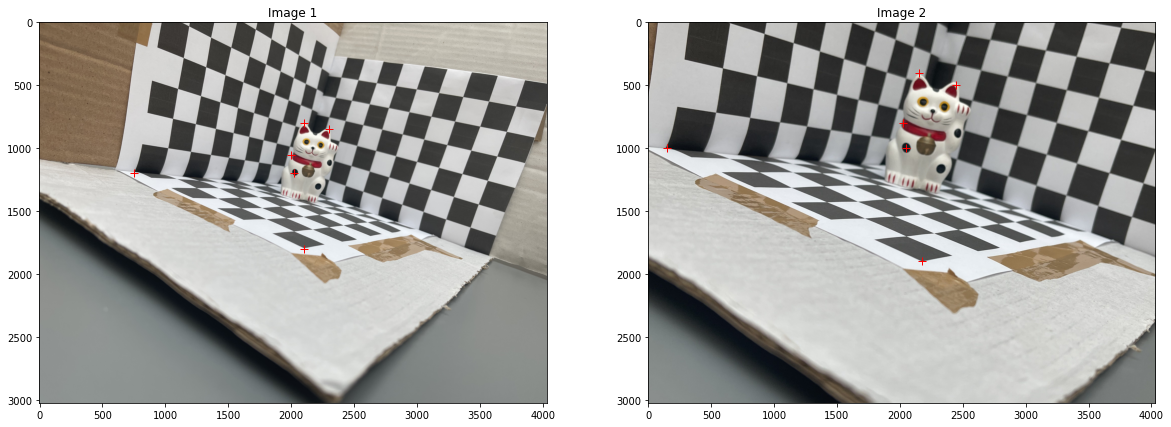

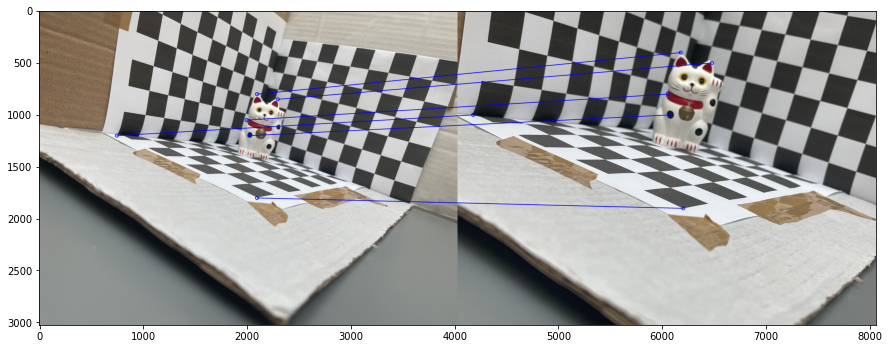

In [8]:
img1 = cv.imread(os.path.join("photos", "keypoint_correspond_1.jpg"))
img2 = cv.imread(os.path.join("photos", "keypoint_correspond_2.jpg"))

kp1 = np.array([[2000, 1050], 
                [2100, 800], 
                [2300, 850],
               [2025, 1200],
               [750, 1200], 
               [2100, 1800]])


kp2 = np.array([[2025, 800], 
                [2150, 400], 
                [2450, 500],
               [2050, 1000],
               [150, 1000], 
               [2175, 1900]])

rows, cols = 1,2
fig = plt.figure(figsize=(20,20))
fig.add_subplot(rows, cols, 1)
plt.imshow(img1[...,::-1])
for coord in kp1:
    plt.plot(coord[0], coord[1], 'r+', markersize=8)
plt.title(f"Image 1")
fig.add_subplot(rows, cols, 2)
plt.imshow(img2[...,::-1])
for coord in kp2:
    plt.plot(coord[0], coord[1], 'r+', markersize=8)
plt.title(f"Image 2")

draw_matches_manual(img1[...,::-1], kp1, img2[...,::-1], kp2)

In [9]:
matches_manual = np.stack([kp1, kp2], axis=-2)

#### Automatic keypoint correspondence using SIFT

In [10]:
def sift_match(img1, img2, ratio=0.3):
    # Initiate SIFT detector
    sift = cv.SIFT_create()
    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)
    # BFMatcher with default params
    bf = cv.BFMatcher()
    matches = bf.knnMatch(des1,des2,k=2)
    # Apply ratio test: see https://stackoverflow.com/questions/51197091/how-does-the-lowes-ratio-test-work
    good = []
    for m,n in matches:
        if m.distance < ratio*n.distance:
            good.append(m)
    return img1, kp1, img2, kp2, good

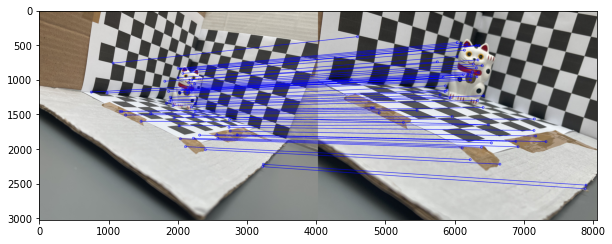

In [11]:
img1, kp1, img2, kp2, good = sift_match(img1, img2, ratio = 0.2)
draw_matches(img1[...,::-1],kp1,img2[...,::-1],kp2, good)

In [12]:
def matches_to_arr(kp1, kp2, matches):
    idxs = []
    for match in matches:
        img1_idx = match.queryIdx
        img2_idx = match.trainIdx
        pair = (kp1[img1_idx].pt, kp2[img2_idx].pt)
        idxs.append(pair)
    return np.array(idxs)

rows, cols, channels = img1.shape

print("Image dims:", rows, cols, channels)

matches_sift = matches_to_arr(kp1, kp2, good)

print("Matches shape:", matches_sift.shape)

Image dims: 3024 4032 3
Matches shape: (63, 2, 2)


### Camera calibration
- Find and report camera parameters.
- Can you estimate or illustrate distortions of your camera?

### Transformation estimation
- Estimate a homography matrix between a pair of images from HG.
    - Show the keypoints and their correspondences projected from the other image.
- Estimate fundamental matrix between a pair of images from FD.
    - Show the keypoints and their corresponding epipolar lines in the other image.
    - Show epipoles, vanishing points and horizon in your images.
- find out how many outliers the estimation method tolerates

#### Homography matrix

In [97]:
img1 = cv.imread(os.path.join("photos", "hg1.jpg"))
img2 = cv.imread(os.path.join("photos", "hg2.jpg"))

In [115]:
def homography(_img1, _img2, ratio):
    img1, kp1, img2, kp2, good = sift_match(_img1.copy(), _img2.copy(), ratio = ratio)
    matches_sift = matches_to_arr(kp1, kp2, good)

    left_keypoints = matches_sift[:,0,:]
    right_keypoints = matches_sift[:,1,:]
    
    print(f"Found {len(left_keypoints)} matches")

    ones = np.ones((left_keypoints.shape[0], 1))
    homog_left_keypoints = np.concatenate([left_keypoints, ones], axis=-1)
    
    draw_matches(img1[...,::-1], kp1, img2[...,::-1], kp2, good)

    M, _ = cv.findHomography(left_keypoints, right_keypoints, cv.RANSAC, 5.0)
    
    print("H = ")
    rows = [r for r in M]
    for r in rows:
        print(" ".join(['{0:.4f}'.format(x) for x in r]))
        
    transformed_left_keypoints = np.array([M @ x for x in homog_left_keypoints])
    z =  transformed_left_keypoints[:, -1]
    transformed_left_keypoints = np.array([transformed_left_keypoints[i] / z[i] for i in range(len(z))])[:, :-1]
    
    plt.figure(figsize=(10,10))
    plt.imshow(img2[...,::-1])
    for i in range(len(right_keypoints)):
        plt.plot(right_keypoints[i][0], right_keypoints[i][1], 'bo', markersize=4)
        plt.plot(transformed_left_keypoints[i][0], transformed_left_keypoints[i][1], 'r+', markersize=8)
    plt.xlim([0, img1.shape[1]])
    plt.ylim([img1.shape[0], 0])
    plt.legend(["Ground truth", "Projected keypoints from other image"])
    
    err = 0
    n = 0

    for i in range(len(right_keypoints)):
        diff = (right_keypoints[i] - transformed_left_keypoints[i])**2
        err += diff[0] + diff[1]
        n += 2

    rmse = np.sqrt(err/n)

    print(f"RMSE = {round((rmse) * 10000)/10000}")  # Root mean square error between ground truth and projected point

Found 51 matches


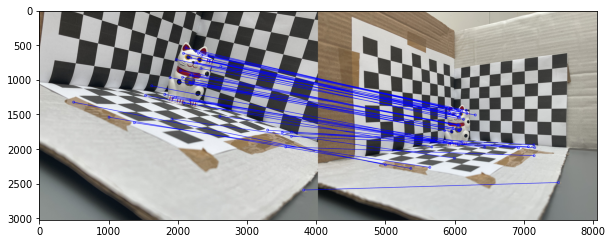

H = 
0.6591 0.0785 475.4074
-0.1478 0.5547 1440.9646
0.0000 -0.0000 1.0000
RMSE = 5.2993


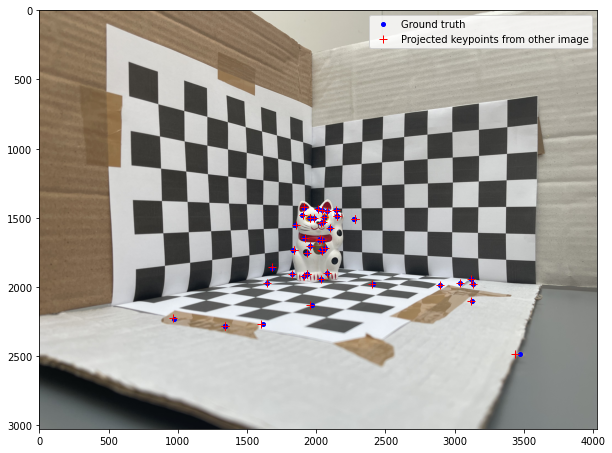

In [102]:
homography(img1, img2, 0.25)

Found 159 matches


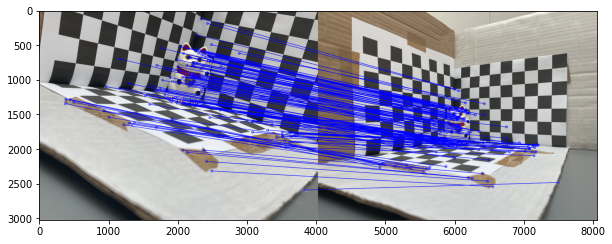

H = 
0.7532 0.0956 374.3399
-0.1127 0.5964 1423.9551
0.0000 -0.0000 1.0000
RMSE = 65.6869


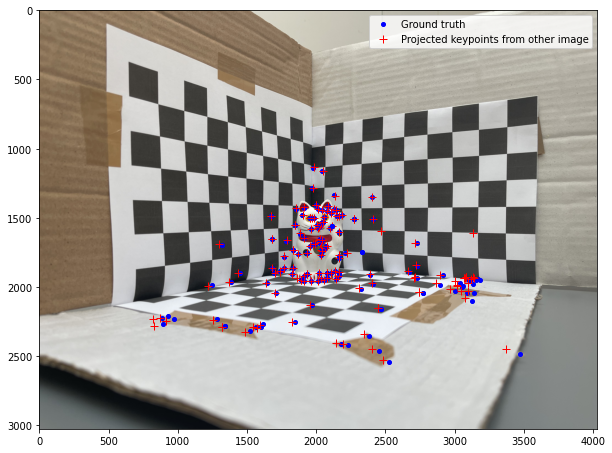

In [103]:
homography(img1, img2, 0.4)

#### Fundamental matrix

In [118]:
img1 = cv.imread(os.path.join("photos", "img5.jpg"))
img2 = cv.imread(os.path.join("photos", "img6.jpg"))

In [119]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    pts1 = pts1.astype(int)
    pts2 = pts2.astype(int)
    r,c, _ = img1.shape
    plt.figure(figsize=(10,10))
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv.line(img1, (x0,y0), (x1,y1), color,20)
        img1 = cv.circle(img1,tuple(pt1),30,color,-1)
        img2 = cv.circle(img2,tuple(pt2),30,color,-1)
    return img1,img2

In [120]:
def fundamental(_img1, _img2, ratio):
    
    img1, kp1, img2, kp2, good = sift_match(_img1.copy(), _img2.copy(), ratio)
    matches_sift = matches_to_arr(kp1, kp2, good)

    left_keypoints = matches_sift[:,0,:]
    right_keypoints = matches_sift[:,1,:]    
    
    print(f"Found {len(left_keypoints)} matches")

    draw_matches(img1[...,::-1], kp1, img2[...,::-1], kp2, good)
    
    F, mask = cv.findFundamentalMat(left_keypoints, right_keypoints, cv.FM_LMEDS)
    
    print("F = ")
    rows = [r for r in F]
    for r in rows:
        print(" ".join(['{0:.4f}'.format(x) for x in r]))
        
    # Find epilines corresponding to points in right image (second image) and
    # drawing its lines on left image
    lines1 = cv.computeCorrespondEpilines(right_keypoints.reshape(-1,1,2), 2,F)
    lines1 = lines1.reshape(-1,3)
    img5,img6 = drawlines(img1,img2,lines1,left_keypoints,right_keypoints)
    # Find epilines corresponding to points in left image (first image) and
    # drawing its lines on right image
    lines2 = cv.computeCorrespondEpilines(left_keypoints.reshape(-1,1,2), 1,F)
    lines2 = lines2.reshape(-1,3)
    img3,img4 = drawlines(img2,img1,lines2,right_keypoints,left_keypoints)
    plt.subplot(121)
    plt.imshow(img5[...,::-1])
    plt.subplot(122)
    plt.imshow(img3[...,::-1])
    plt.show()
    
    # Checking that x'Fx = 0

    one = np.array([1])
    res = 0
    for i in range(len(right_keypoints)):
        res += np.concatenate([right_keypoints[i], one]) @ F @ np.concatenate([left_keypoints[i], one])
    print(f"Average value of x'Fx = {res/len(right_keypoints)}") # If this number is very low this means F is correct

Found 8 matches


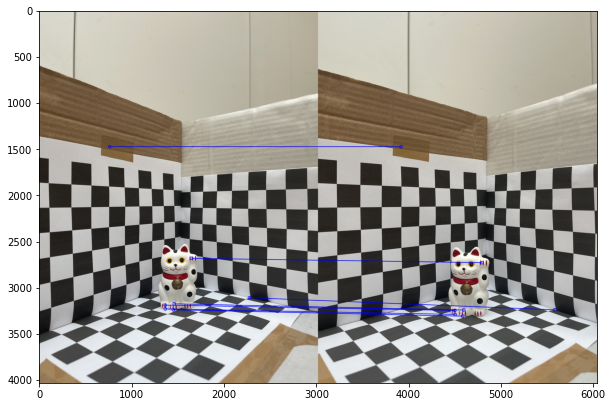

F = 
0.0000 0.0000 -0.0050
-0.0000 -0.0000 0.0015
0.0045 -0.0018 1.0000


<Figure size 720x720 with 0 Axes>

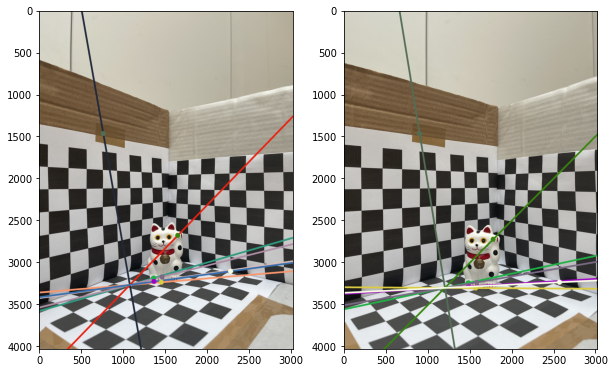

Average value of x'Fx = 5.551115123125783e-17


In [121]:
fundamental(img1, img2, 0.24)

Found 70 matches


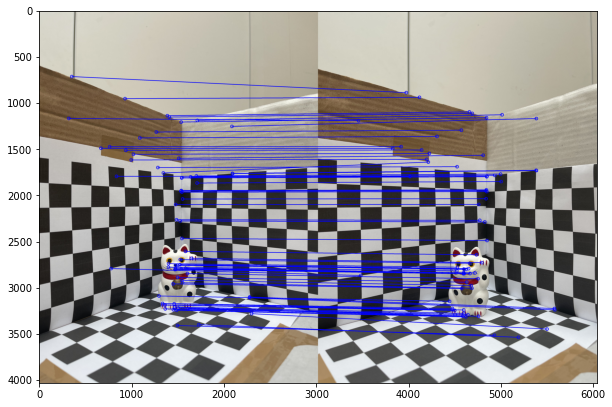

F = 
0.0000 -0.0000 0.0014
0.0000 -0.0000 -0.0128
-0.0031 0.0123 1.0000


<Figure size 720x720 with 0 Axes>

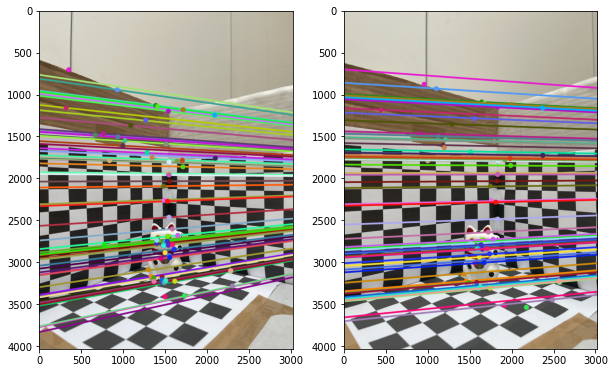

Average value of x'Fx = -0.028627182368785257


In [122]:
fundamental(img1, img2, 0.4)

### 3D geometry
- Show a stereo rectified pair of your images with epipolar lines.
- Calculate and display depth map of your object estimated from different views.